# SHAP - Logistic regression

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we'll use the approximation of Shapley values that is suitable for linear models to interpret the log(Odds).

Then, we'll interpret the probabilities by estimating SHAP with a model agnostic method.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import shap

### Load data

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic2.csv')

to_drop = [
    "parch", "embarked_S", "embarked_C", "cabin_C", "cabin_B", "cabin_E",
    "cabin_D", "cabin_A", "cabin_G"
]

df.drop(to_drop, axis=1, inplace=True)

df.head()

,pclass,sibsp,survived,fare,sex_female,cabin_M
0,1,0,1,211.3375,1,0
1,1,1,1,151.5500,0,0
2,1,1,0,151.5500,1,0
3,1,1,0,151.5500,0,0
4,1,1,0,151.5500,1,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 5), (197, 5))

In [4]:
# scale the variables
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# display top 5 rows
X_train.head()

,pclass,sibsp,fare,sex_female,cabin_M
1021,0.834271,-0.474139,-0.490185,-0.739319,0.539927
512,-0.367425,0.469050,-0.060516,-0.739319,0.539927
957,0.834271,2.355428,-0.149726,1.352596,0.539927
1066,0.834271,-0.474139,-0.503101,-0.739319,0.539927
1259,0.834271,-0.474139,-0.490185,-0.739319,0.539927


## Logistic regression

In [5]:
logit = LogisticRegression(random_state=1)

logit.fit(X_train, y_train)

# Accuracy in test set
logit.score(X_test, y_test)

0.8426395939086294

In [6]:
# coefficients

coeffs = pd.Series(logit.coef_[0], index=logit.feature_names_in_)
coeffs

pclass       -0.484112
sibsp        -0.225560
fare          0.020358
sex_female    1.171343
cabin_M      -0.326350
dtype: float64

## Feature effects

Let's take an individual observation and evaluate how its feature values contribute towards survival. This is given by the feature's values multiplied by the model coefficients, which returns the change in the log(odds) resulting from each feature.

In [7]:
# reset index so we can compare with outpuf of SHAP later

X_test.reset_index(inplace=True, drop=True)

In [8]:
# we'll explain one observations from this view

X_test.tail()

,pclass,sibsp,fare,sex_female,cabin_M
192,-0.367425,0.469050,-0.374654,1.352596,0.539927
193,0.834271,-0.474139,-0.490991,-0.739319,0.539927
194,-1.569122,0.469050,0.364390,1.352596,-1.852101
195,-0.367425,0.469050,-0.105485,1.352596,0.539927
196,0.834271,-0.474139,-0.405090,1.352596,0.539927


In [9]:
obs = 193

# feature values
X_test.loc[obs]

pclass        0.834271
sibsp        -0.474139
fare         -0.490991
sex_female   -0.739319
cabin_M       0.539927
Name: 193, dtype: float64

In [10]:
# change in log(odds) resulting from each feature

effect = coeffs * X_test.loc[obs]
effect

pclass       -0.403881
sibsp         0.106947
fare         -0.009996
sex_female   -0.865996
cabin_M      -0.176205
dtype: float64

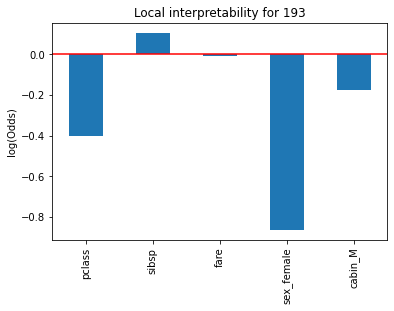

In [11]:
effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("log(Odds)")
plt.title(f"Local interpretability for {obs}")
plt.show()

In [12]:
# prediction of the observation being explained

preds = logit.predict_proba(X_test)

preds[obs]

array([0.87991242, 0.12008758])

## SHAP manual

We'll calculate the SHAP values manually as we discussed in the video. The manual calculation is only suitable to explain log(Odds) and not probabilities.

In [13]:
# the mean value of each variable

X_train.mean()

pclass        1.341852e-16
sibsp         5.750796e-17
fare          3.833864e-17
sex_female   -5.910540e-17
cabin_M       5.111818e-17
dtype: float64

In [14]:
# the expected (mean) effect for each variable

coeffs * X_train.mean()

pclass       -6.496071e-17
sibsp        -1.297151e-17
fare          7.804984e-19
sex_female   -6.923271e-17
cabin_M      -1.668243e-17
dtype: float64

In [15]:
# the shap value for each variable (log odds)

effect - coeffs * X_train.mean()

pclass       -0.403881
sibsp         0.106947
fare         -0.009996
sex_female   -0.865996
cabin_M      -0.176205
dtype: float64

## SHAP for log odds

We'll now use the SHAP library. The `LinearExplainer` will explain the log(Odds) automatically, regardless of whether we pass a link function. In fact, that argument is ignored.

In [16]:
# we don't need a link function. I leave it as a reminder that we can 
# pass it or not and we'll obtain the same results.

explainer = shap.LinearExplainer(logit, X_train, link=shap.links.logit)

In [17]:
shap_values = explainer(X_test)

In [18]:
# these values don't coincide with those calculated manually.
# That's because by default, LinearExplainer uses only 100 observations
# from the data. 

shap_values[obs]

.values =
array([-0.40722924,  0.10211807, -0.00878069, -0.83311919, -0.21077256])

.base_values =
-0.6338174640934118

.data =
array([ 0.83427143, -0.47413915, -0.49099109, -0.73931894,  0.5399273 ])

**Important**

The difference in the values that we see between the SHAP library and the manual calculation are due to the SHAP library using **only 100 values** from the training set by default to estimate the expected mean effect.

See this [stackoverflow thread](https://stackoverflow.com/questions/78796974/shap-values-for-linear-model-different-from-those-calculated-manually) for more details. That is true for SHAP version 0.46.0.

To override this behaviour, we need to set up the explainer like this:

In [19]:
# to use the entire background data:

explainer = shap.LinearExplainer(
    logit,
    shap.maskers.Independent(X_train, max_samples=len(X_train)),
)

shap_values = explainer(X_test)
shap_values[obs]

.values =
array([-0.403881  ,  0.10694695, -0.0099956 , -0.8659962 , -0.17620541])

.base_values =
-0.6424698035301213

.data =
array([ 0.83427143, -0.47413915, -0.49099109, -0.73931894,  0.5399273 ])

We can plot the change in the log(odds) according to the Shapley values per feature.

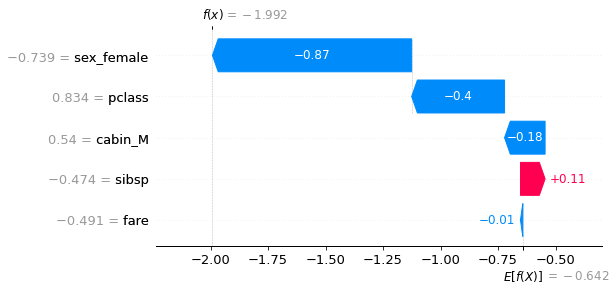

In [20]:
# data index, :, class index

shap.plots.waterfall(shap_values[obs])

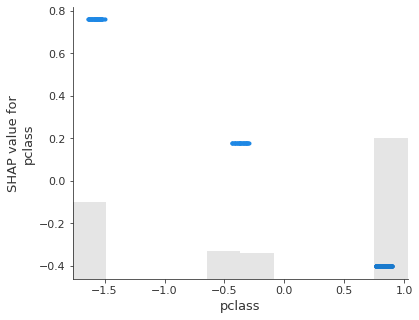

In [21]:
# we can see the change in the Shapley value as the feature value increases
# we are measuring in log odds, so it should be linear.

shap.plots.scatter(shap_values[:,"pclass"])

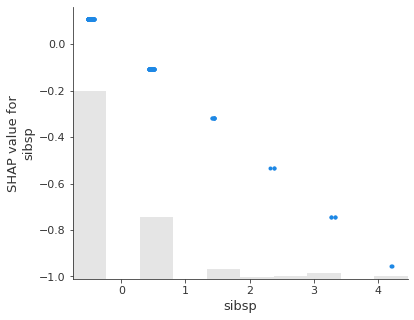

In [22]:
shap.plots.scatter(shap_values[:,"sibsp"])

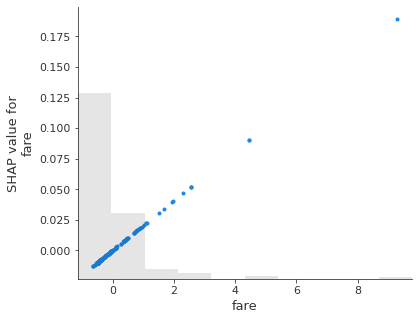

In [23]:
shap.plots.scatter(shap_values[:,"fare"])

## SHAP for probabilities

Now, we want to explain how the probability changes when the feature values changes. We need to use a different algorithm to estimate the Shapley values.

In [24]:
# to explain probabilities we need a different explainer

explainer = shap.Explainer(logit.predict_proba, X_train)

shap_values = explainer(X_test)

In [25]:
# in this case, it choses the Exact explainer because we
# have few features.

explainer.__class__

shap.explainers._exact.ExactExplainer

In [26]:
# these values coincide with those calculated manually
# as discussed in the intro video

shap_values[obs]

.values =
array([[ 0.06903592, -0.06903592],
       [-0.01243739,  0.01243739],
       [ 0.00133641, -0.00133641],
       [ 0.16790367, -0.16790367],
       [ 0.03603822, -0.03603822]])

.base_values =
array([0.6180356, 0.3819644])

.data =
array([ 0.83427143, -0.47413915, -0.49099109, -0.73931894,  0.5399273 ])

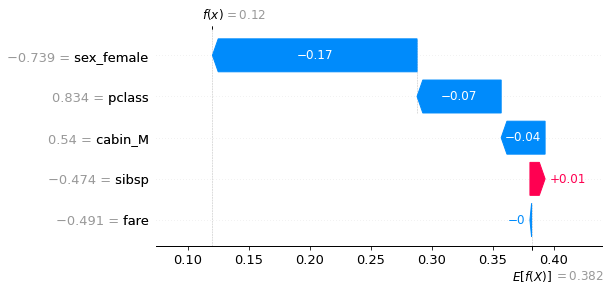

In [27]:
shap.plots.waterfall(shap_values[obs, :, 1])

The relationship between Shapley values and feature values may not be linear.

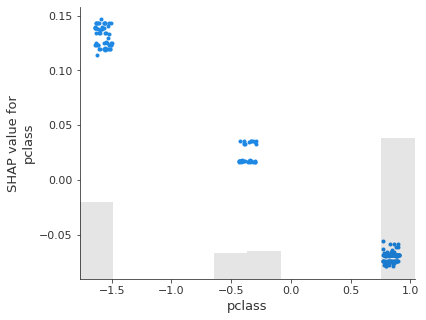

In [28]:
shap.plots.scatter(shap_values[:,"pclass", 1])

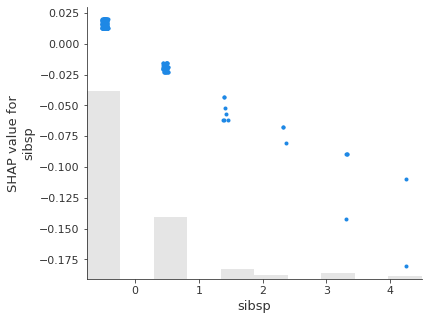

In [29]:
shap.plots.scatter(shap_values[:,"sibsp", 1])

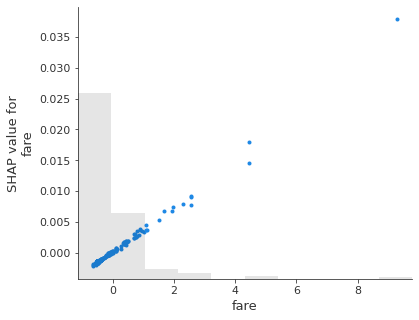

In [30]:
shap.plots.scatter(shap_values[:,"fare", 1])